# <center>Tiền xử lý ảnh</center>
Name: Ngo Thi Minh Thu

Email: ngothiminhthu02@gmail.com

## 1. Vai trò của tiền xử lý ảnh

Khi phát triển một thuật toán phân loại ảnh chúng ta có thể gặp phải một số trường hợp không mong đợi như: Kết quả huấn luyện có độ chính xác rất cao trên cả tập huấn luyện (train dataset) và tập phát triển (dev dataset). Nhưng khi áp dụng vào thực tiễn lại cho độ chính xác thấp. Có rất nhiều các nguyên nhân dẫn tới điều này và một trong số đó là:
- Các bức ảnh được huấn luyện khác xa so với những bức ảnh được người dùng upload
- Có thể các bức ảnh được người dùng upload lên mặc dù cùng nhãn nhưng khác về tính chất so với các bức ảnh đã huấn luyện.
- Đối với một số tác vụ phân loại ảnh khó, đòi hỏi chuyên gia gán nhãn, rất dễ mắc sai lầm như chuẩn đoán bệnh nhãn cầu. 
- Bộ dữ liệu huấn luyện có kích thước quá nhỏ và không đại diện cho toàn bộ các class được huấn luyện.
- Phân phối của tập huấn luyện khác xa so với thực tế.

Khi đối mặt với trường hợp trên chúng ta cần phải tìm ra nguyên nhân thực sự là gì để từ đó đưa ra phương án thích hợp khắc phục các lỗi mô hình.

Thay đổi tập dữ liệu huấn luyện và tập dữ liệu phát triển, thống kê lỗi và tìm cách giải quyết các lỗi chính mang lại cải thiện lớn, xác định tập huấn luyện/phát triển và phép đo đơn trị thích hợp ngay từ đầu cho bài toán, áp dụng các phương pháp và kiến trúc mô hình khác nhau,…

## 2. Tiền xử lý ảnh
### 2.1. Các biến đổi hình học.
Đây là tập hợp các phép biến đổi hình ảnh từ một hình dạng này sang một hình dạng khác thông qua việc làm thay đổi phương, chiều, góc, cạnh mà không làm thay đổi nội dung chính của bức ảnh. 
### Định nghĩa:
Mỗi một phép biến đổi hình học sẽ được xác định bởi một ma trận dịch chuyển (translation matrix) **M**. Khi đó bất kì 1 điểm có tọa độ trên ảnh gốc thông qua phép biến đổi **T** sẽ có tọa độ (x,y) trong không gian mới sau dịch chuyển là **T(x,y)** theo công thức:
<img src="matrixM.png">

### 2.1.1. Phóng đại ảnh (Scale ảnh)

Scale ảnh là việc chúng ta thay đổi kích thước dài, rộng của ảnh mà không làm thay đổi tính chất song song của các đoạn thẳng trên ảnh gốc so với các trục tọa độ X và Y. 
Khi đó M là ma trận vuông có đường chéo chính là các hệ số phóng đại và các phần tử còn lại bằng 0. 
<img src="2.png">
Trong opencv, chúng ta sẽ thay đổi kích thước của hình ảnh bằng hàm cv2.resize().

origin image shape: (709, 621, 3)
scale image shape: (1418, 1242, 3)


(<AxesSubplot:title={'center':'Scale Image'}>,
 Text(0.5, 1.0, 'Scale Image'))

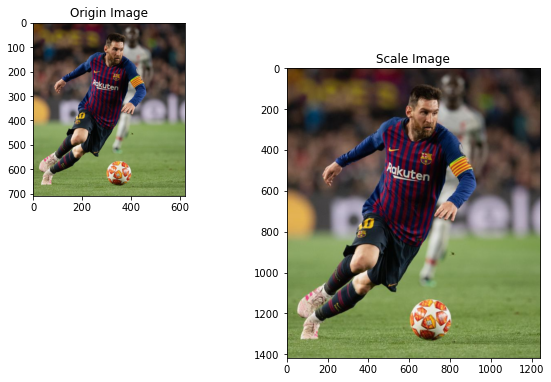

In [3]:
import cv2
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

url = 'https://i.imgur.com/1vzDG2J.jpg'
def _downloadImage(url):
  resp = requests.get(url)
  img = np.asarray(bytearray(resp.content), dtype="uint8")
  img = cv2.imdecode(img, cv2.IMREAD_COLOR)
  return img
  
img = _downloadImage(url)
print('origin image shape: {}'.format(img.shape))

# Scale image bằng cách gấp đôi width and height
h, w = img.shape[:2]
imgScale = cv2.resize(img, (int(w*2), int(h*2)), interpolation = cv2.INTER_LINEAR)
print('scale image shape: {}'.format(imgScale.shape))

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Origin Image')
fig.add_subplot(rows, columns, 2)
plt.subplot(122),plt.imshow(cv2.cvtColor(imgScale, cv2.COLOR_BGR2RGB)),plt.title('Scale Image')

Như vậy bức ảnh đã được resize về một kích thước gấp đôi cả về chiều width và height nhưng không làm nội dung ảnh thay đổi. Resize ảnh rất thường xuyên được sử dụng trong các mô hình deep learning phân loại ảnh vì mỗi một mô hình đều có một kích thước đầu vào tiêu chuẩn. Chẳng hạn như Lenet là kích thước 32x32x3 và Alexnet là 224x224x3.

### 2.1.2. Dịch chuyển ảnh (Translation)
Dịch hình ảnh là một trong những thao tác cơ bản nhất trong chỉnh sửa hình ảnh và thuộc phép biến đổi Affine – là phép biến đổi hình học bảo toàn các đường thẳng và song song (nhưng không nhất thiết là khoảng cách và góc). 

Trong thị giác máy tính, việc dịch một hình ảnh có nghĩa là dịch chuyển nó theo một số pixel cụ thể, dọc theo các trục x và y. Đặt các pixel mà hình ảnh cần dịch chuyển là tx và ty. Xác định ma trận dịch M có dạng như sau:
<img src="3.png">
<img src="4.png">
Một số điểm cần lưu ý khi thay đổi hình ảnh theo các giá trị tx và ty.
- Giá trị tx dương sẽ chuyển hình ảnh sang phải và các giá trị âm sẽ chuyển hình ảnh sang trái.
- Tương tự, các giá trị dương của ty sẽ chuyển hình ảnh xuống trong khi các giá trị âm sẽ chuyển hình ảnh lên trên.

Trong opencv, Áp dụng hàm **cv2.warpAffine()** với đầu vào là ma trận dịch chuyển và bức ảnh gốc ta thu được kết quả là ảnh sau dịch chuyển.

Biến đổi afin https://vi.wikipedia.org/wiki/Bi%E1%BA%BFn_%C4%91%E1%BB%95i_afin

(<AxesSubplot:title={'center':'Translate to Up Left'}>,
 Text(0.5, 1.0, 'Translate to Up Left'))

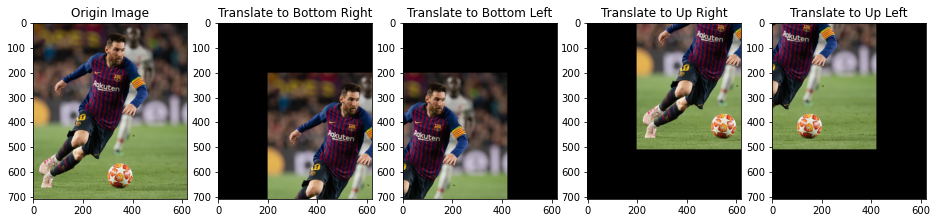

In [13]:
rows, cols = img.shape[:2]
# Dịch chuyển hình ảnh xuống góc dưới bên phải
tx, ty = (200, 200)
M1 = np.array([[1, 0, tx], 
              [0, 1, ty]], dtype=np.float32)
tran1 = cv2.warpAffine(img, M1, (cols, rows))

# Dịch chuyển hình ảnh xuống góc dưới bên trái
M2 = np.array([[1, 0, -tx], 
              [0, 1, ty]], dtype=np.float32)
tran2 = cv2.warpAffine(img, M2, (cols, rows))

# Dịch chuyển hình ảnh xuống góc dưới bên trái
M3 = np.array([[1, 0, tx], 
              [0, 1, -ty]], dtype=np.float32)
tran3 = cv2.warpAffine(img, M3, (cols, rows))

# Dịch chuyển hình ảnh xuống góc dưới bên trái
M4 = np.array([[1, 0, -tx], 
              [0, 1, -ty]], dtype=np.float32)
tran4 = cv2.warpAffine(img, M4, (cols, rows))

plt.figure(figsize=(16, 4))
plt.subplot(151),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Origin Image')
plt.subplot(152),plt.imshow(cv2.cvtColor(tran1, cv2.COLOR_BGR2RGB)),plt.title('Translate to Bottom Right')
plt.subplot(153),plt.imshow(cv2.cvtColor(tran2, cv2.COLOR_BGR2RGB)),plt.title('Translate to Bottom Left')
plt.subplot(154),plt.imshow(cv2.cvtColor(tran3, cv2.COLOR_BGR2RGB)),plt.title('Translate to Up Right')
plt.subplot(155),plt.imshow(cv2.cvtColor(tran4, cv2.COLOR_BGR2RGB)),plt.title('Translate to Up Left')

Lưu ý: warpAffine() là một hàm chung có thể được sử dụng để áp dụng bất kỳ kiểu chuyển đổi affine nào cho một hình ảnh. Chỉ cần xác định ma trận M một cách thích hợp.

### 2.1.2. Xoay ảnh (Rotation)
Xoay ảnh được hiểu là ta quay một bức ảnh theo một góc xác định quanh một điểm nào đó. Phép xoay sẽ không đảm bảo tính chất song song với các trục X hoặc Y như phép dịch chuyển nhưng nó sẽ bảo toàn độ lớn góc. 
Bạn có thể xoay một ảnh với một góc θ bằng cách xác định ma trận chuyển đổi M có dạng như sau:
<img src = "5.png">
Ngoài ra OpenCV hỗ trợ một phép xoay phóng đại (scaled rotation) với khả năng vừa biến đổi ảnh theo phép xoay theo tâm xác định và điều chỉnh lại kích thước ảnh sau xoay. Như vậy bạn có thể xoay theo bất kì vùng nào mà bạn muốn. Phép dịch chuyển ma trận được đưa ra như sau:
<img src = "6.png">
Trong đó cx & cy là tọa độ mà hình ảnh được xoay.

Hàm getRotationMatrix2D() gồm các đối số sau:
- center: tâm xoay của hình ảnh
- angle: góc quay theo độ
- scale: hệ số tỷ lệ đẳng hướng giúp chia tỷ lệ hình ảnh lên hoặc xuống theo giá trị được khai báo.

Nếu angle dương, hình ảnh sẽ được quay theo hướng ngược chiều kim đồng hồ. Nếu muốn xoay hình ảnh theo chiều kim đồng hồ với cùng một lượng, thì angle cần phải âm.

Bên dưới là một ví dụ xoay ảnh kích thước 45 độ tại tâm của ảnh.

(<AxesSubplot:title={'center':'Rotate 20 at bottom right corner'}>,
 Text(0.5, 1.0, 'Rotate 20 at bottom right corner'))

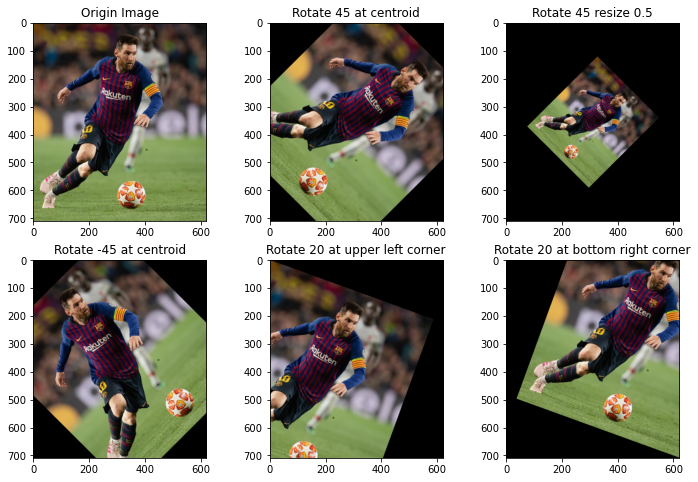

In [14]:
# Xoay ảnh kích thước 45 độ tại tâm của ảnh, độ phóng đại ảnh không đổi.
M5 = cv2.getRotationMatrix2D(center = (cols/2,rows/2), angle=-45, scale=1)
tran5 = cv2.warpAffine(img, M5, (cols,rows))

# Xoay ảnh kích thước 45 độ tại tâm của ảnh và độ phóng đại giảm 1/2
M6 = cv2.getRotationMatrix2D(center = (cols/2,rows/2), angle=-45, scale=0.5)
tran6 = cv2.warpAffine(img, M6, (cols,rows))

# Xoay ảnh kích thước -45 độ tại tâm của ảnh
M7 = cv2.getRotationMatrix2D(center = (cols/2,rows/2), angle=45, scale=1)
tran7 = cv2.warpAffine(img, M7, (cols,rows))

# Xoay ảnh kích thước 20 độ tại góc trên bên trái
M8 = cv2.getRotationMatrix2D(center = (0, 0), angle=-20, scale=1)
tran8 = cv2.warpAffine(img, M8, (cols,rows))

# Xoay ảnh kích thước 20 độ tại góc dưới bên phải
M9 = cv2.getRotationMatrix2D(center = (cols,rows), angle=-20, scale=1)
tran9 = cv2.warpAffine(img, M9, (cols,rows))

plt.figure(figsize=(12, 8))
plt.subplot(231),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Origin Image')
plt.subplot(232),plt.imshow(cv2.cvtColor(tran5, cv2.COLOR_BGR2RGB)),plt.title('Rotate 45 at centroid')
plt.subplot(233),plt.imshow(cv2.cvtColor(tran6, cv2.COLOR_BGR2RGB)),plt.title('Rotate 45 resize 0.5')
plt.subplot(234),plt.imshow(cv2.cvtColor(tran7, cv2.COLOR_BGR2RGB)),plt.title('Rotate -45 at centroid')
plt.subplot(235),plt.imshow(cv2.cvtColor(tran8, cv2.COLOR_BGR2RGB)),plt.title('Rotate 20 at upper left corner')
plt.subplot(236),plt.imshow(cv2.cvtColor(tran9, cv2.COLOR_BGR2RGB)),plt.title('Rotate 20 at bottom right corner')

### 2.1.3. Biến đổi Affine

Trong biến đổi affine, toàn bộ các đường thẳng song song trong bức ảnh gốc giữ nguyên tính chất song song ở ảnh đầu ra. Để tìm ma trận chuyển vị, chúng ta cần xác định ra 3 điểm từ ảnh đầu vào và tọa độ tương ứng của chúng trong hình ảnh đầu ra. Hàm cv2.getAffineTransform sẽ tạo ra được một ma trận 2x3 được truyền vào hàm cv2.warpAffine.

Kiểm tra ví dụ bên dưới, chúng ta cùng nhìn vào các điểm mà tôi lựa chọn (được đánh dấu x, màu trắng).

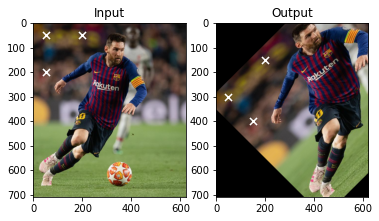

In [15]:
rows,cols,ch = img.shape

pts1 = np.float32([[50,50], [200,50], [50,200]])
# pts2 = np.float32([[50,100], [200,50], [50,200]])
pts2 = np.float32([[50,300], [200,150], [150, 400]])

M = cv2.getAffineTransform(pts1,pts2)
imageAffine = cv2.warpAffine(img,M,(cols,rows))

# Hiển thị hình ảnh gốc và 3 điểm ban đầu trên ảnh
plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Input')
for (x, y) in pts1:
    plt.scatter(x, y, s=50, c='white', marker='x')

# Hiển thị hình ảnh sau dịch chuyển và 3 điểm mục tiêu của phép dịch chuyển.
plt.subplot(122),plt.imshow(cv2.cvtColor(imageAffine, cv2.COLOR_BGR2RGB)),plt.title('Output')
for (x, y) in pts2:
    plt.scatter(x, y, s=50, c='white', marker='x')

Như vậy sử dụng phép biến đổi Affine có thể giúp ta tạo thành nhiều biến thể, tư thế khác nhau cho cùng một vật thể. Thường được áp dụng trong Data Augumentation để làm giàu dữ liệu trong trường hợp số lượng ảnh không nhiều. 

### 2.1.4. Biến đổi phối cảnh (Perspective Transform)

Để biến đổi phối cảnh thì chúng ta cần một ma trận biến đổi 3x3. Đường thẳng sẽ giữ nguyên là đường thẳng sau biến đổi. Để tìm ra ma trận biến đổi này, chúng ta cần tìm ra 4 điểm trong ảnh đầu vào tương ứng với các điểm trong ảnh đầu ra. Trong số 4 điểm này, không có bất kì 3 điểm nào thẳng hàng. Sau đó ma trận biến đổi có thể được thiết lập thông qua hàm số cv2.getPerspectiveTransform. Và áp dụng cv2.warpPerspective với ma trận biến đổi 3x3

<img src='per.png'>

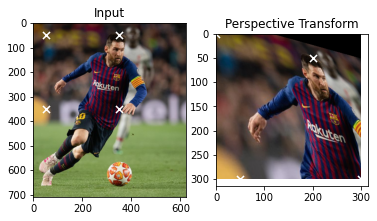

In [16]:
pts1 = np.float32([[50,50],[350,50],[50,350],[350,350]])
pts2 = np.float32([[0,0],[200,50],[50,300],[300,300]])

M = cv2.getPerspectiveTransform(pts1,pts2)

dst = cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Input')
for (x, y) in pts1:
  plt.scatter(x, y, s=50, c='white', marker='x')
plt.subplot(122),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Perspective Transform')
for (x, y) in pts2:
  plt.scatter(x, y, s=50, c='white', marker='x')
plt.show()

Như vậy phép biến đổi này cũng gần giống như phép biến đổi Affine. Khác biệt đó là nó chỉ trả ra bức ảnh là biến đổi trên vùng ảnh bị giới hạn trong tọa độ của 4 điểm gốc thay vì biến đổi trên toàn bộ bức ảnh ban đầu như phép biến đổi Affine. Trong trường hợp muốn crop ảnh ta sẽ xác định trước tọa độ của 4 góc và sử dụng phép biến đổi phối cảnh giữa 4 điểm với chính các điểm đó.

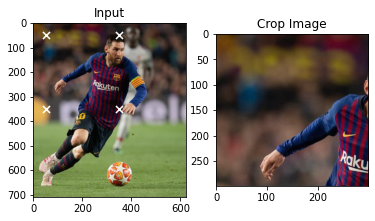

In [17]:
pts1 = np.float32([[50,50],[350,50],[50,350],[350,350]])

M = cv2.getPerspectiveTransform(pts1,pts1)

dst = cv2.warpPerspective(img,M,(300,300))

plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Input')
for (x, y) in pts1:
  plt.scatter(x, y, s=50, c='white', marker='x')
plt.subplot(122),plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)),plt.title('Crop Image')
plt.show()

### 2.1.5 Flip
Sử dụng cv2.flip() với tham số truyền vào là ảnh ban đầu và tham số thứ hai là **0** nếu muốn lật ảnh theo chiều dọc, **1** nếu muốn lật ảnh theo chiều ngang, bạn có thể sử dụng giá trị âm để lật ảnh hai trục.

(<AxesSubplot:title={'center':'Flips the image around both axes'}>,
 Text(0.5, 1.0, 'Flips the image around both axes'))

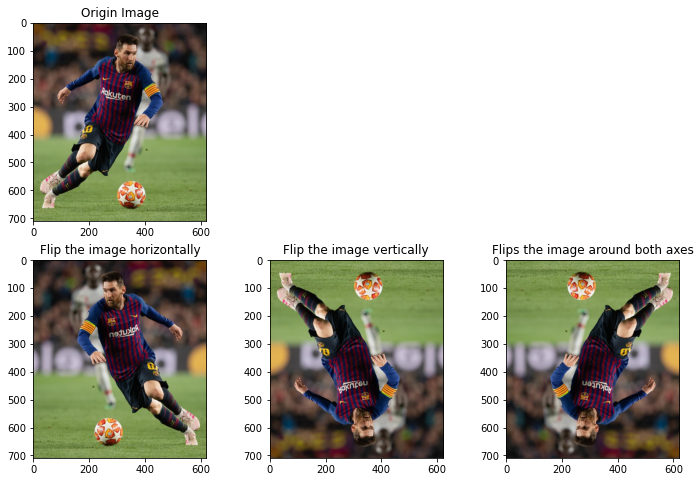

In [21]:
flip1 = cv2.flip(img, 1)
flip2 = cv2.flip(img, 0)
flip3 = cv2.flip(img, -1)

plt.figure(figsize=(12, 8))
plt.subplot(231),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.title('Origin Image')
plt.subplot(234),plt.imshow(cv2.cvtColor(flip1, cv2.COLOR_BGR2RGB)),plt.title('Flip the image horizontally')
plt.subplot(235),plt.imshow(cv2.cvtColor(flip2, cv2.COLOR_BGR2RGB)),plt.title('Flip the image vertically')
plt.subplot(236),plt.imshow(cv2.cvtColor(flip3, cv2.COLOR_BGR2RGB)),plt.title('Flips the image around both axes')

## 2.2. Làm mịn ảnh (smoothing images)
Nhiễu là sản phẩm phụ không mong muốn của quá trình thu nhận và xử lý hình ảnh. Nó có thể che khuất nội dung mục tiêu của hình ảnh và giới thiệu các hiện vật có thể làm giảm chất lượng của hình ảnh.

Chúng ta có thể lọc nhiễu cho ảnh bằng bộ lọc tích chập 2 chiều (2D convolution), hoặc làm mờ ảnh bằng bộ lọc trung bình hoặc Gaussian Filtering.
### 2.2.1. Bộ lọc tích chập 2D (2D convolution)

Như đối với tín hiệu 1 chiều, các hình ảnh cũng được lọc với đa dạng các bộ lọc truyền dẫn thấp (low-pass filters LPF), bộ lọc truyền dẫn cao (high-pass fiters HPF). Một HPF sẽ giúp ta tìm ra các cạnh trong một hình ảnh, còn LPF sẽ lọc nhiễu cho ảnh và làm mờ ảnh.

LPF cho tan so thap di qua

OpenCV đưa ra một hàm cv2.filter2D() để tích chập một bộ lọc (kernel) với một hình ảnh. Chẳng hạn như bên dưới chúng ta sẽ thử lọc trung bình trên một bức ảnh. thông qua phép nhân tích chập với một bộ lọc trung bình kích thước 5x5 như bên dưới.
<img src = "7.png">
Khi đó mỗi một vùng ảnh cục bộ (local region) kích thước 5x5 trên ảnh gốc, các pixels sẽ được lấy giá trị bằng nhau và bằng trung bình của toàn bộ các pixels trên vùng ảnh. Dịch chuyển bộ lọc trên toàn bộ các vùng ảnh gốc như một phép tích chập 2 chiều thông thường ta sẽ được ảnh smoothing. Cụ thể như code bên dưới.

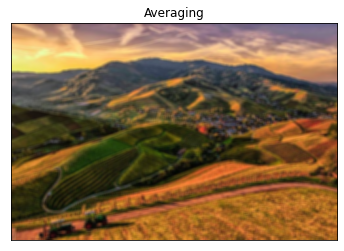

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("4k.jpeg")[:,:,::-1]
kernel = np.ones((5,5),np.float32)/25

imgSmooth = cv2.filter2D(img,-1,kernel)

rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
fig.add_subplot(rows, columns, 2)
plt.imshow(imgSmooth),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()

### 2.2.2. Làm mờ ảnh (Image blurring)

Các ảnh mờ có thể thu được thông qua phép tích chập hình ảnh với các bộ lọc LPF. Đây là những bộ lọc rất hữu ích trong loại bỏ nhiễu. Trên thực tế nó loại bỏ các nội dung tần số cao (chẳng hạn như nhiễu, các cạnh) khỏi hình ảnh dẫn đến các cạnh bị làm mờ khi bộ lọc được áp dụng. Có rất nhiều kĩ thuật làm mờ ảnh mà không làm mờ các cạnh. OpenCV cung cấp 4 kĩ thuật làm mờ chủ yếu.
Những lợi ích của việc làm mờ là sau:

    Nó loại bỏ các cạnh cường độ thấp.
    Nó giúp làm mịn hình ảnh.
    Nó có lợi trong việc che giấu các chi tiết; ví dụ, cần phải làm mờ trong nhiều trường hợp, chẳng hạn như cảnh sát cố tình muốn giấu mặt nạn nhân.

#### 1. Trung bình (Average)

Tương tự như tích chập 2 chiều, chúng cũng sử dụng một ma trận vuông 2 chiều gồm toàn giá trị 1 để lấy trung bình trên các vùng cục bộ. Chúng ta có thể thực hiện thông qua các hàm cv2.blur() và cv2.boxFilter(). Chẳng hạn như ta làm như bên dưới:

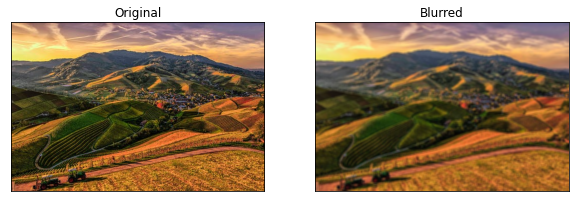

In [204]:
blur = cv2.blur(img,(5,5))

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
fig.add_subplot(rows, columns, 2)
plt.imshow(blur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

#### 2. Bộ lọc Gausian

Bộ lọc gaussian được khởi tạo thông qua hàm cv2.GaussianBlur(). Chúng ta cần xác định độ lệch chuẩn theo 2 phương X và Y. Bộ lọc Gaussian rất hiệu quả trong việc xóa bỏ noise khỏi hình ảnh.

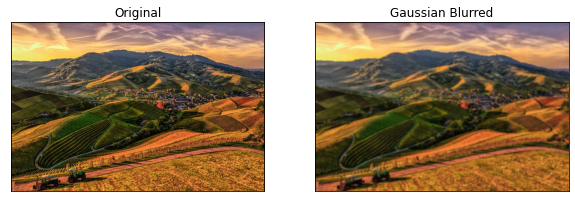

In [200]:
gaussian_img = cv2.GaussianBlur(img, (5, 5), 0)
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
fig.add_subplot(rows, columns, 2)
plt.imshow(gaussian_img),plt.title('Gaussian Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

Ngoài ra ta còn có các bộ lọc:
- median: Được khởi tạo thông qua hàm cv2.medianBlur(). Cũng tương tự như bộ lọc trung bình, nhưng thay vì tính mean thì ta tính toán các median của toàn bộ các pixels trên một vùng cục bộ và thay thế các điểm ảnh trên vùng cục bộ bằng median.
- bilateral: Được khởi tạo thông qua hàm cv2.bilateralFilter(). Các bộ lọc trình bày trước đó cho thấy có xu hướng làm mờ cạnh. Tuy nhiên bộ lọc này lại chỉ remove nhiễu mà vẫn bảo tồn được các cạnh.


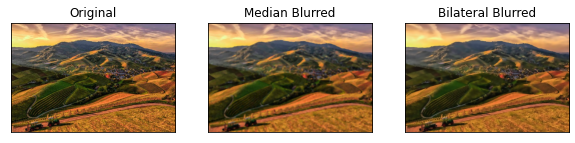

In [205]:
median_img = cv2.medianBlur(img, 5, 0)
bilateral_img = cv2.bilateralFilter(img, 9, 75, 75)

fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
fig.add_subplot(rows, columns, 2)
plt.subplot(132),plt.imshow(median_img),plt.title('Median Blurred')
plt.xticks([]), plt.yticks([])
fig.add_subplot(rows, columns, 3)
plt.subplot(133),plt.imshow(bilateral_img),plt.title('Bilateral Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

### 2.2.3 Sharpening Images


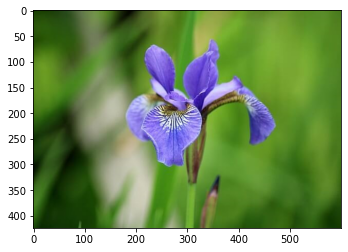

In [214]:
img = cv2.imread("iris.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

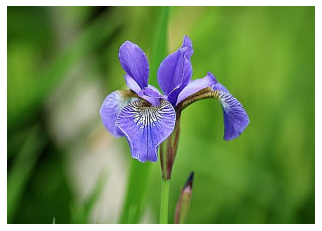

In [216]:
# Create kernel
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
# Sharpen image
image_sharp = cv2.filter2D(image, -1, kernel)
# Show image
plt.imshow(cv2.cvtColor(image_sharp, cv2.COLOR_BGR2RGB)), plt.axis("off")
plt.show()

### 2.2.4 Enhancing Contrast
We want to increase the contrast between pixels in an image

Histogram equalization is a tool for image processing that can make objects and
shapes stand out. When we have a grayscale image, we can apply OpenCV’s equalizeHist directly on the image

However, when we have a color image, we first need to convert the image to the YUV
color format. The Y is the luma, or brightness, and U and V denote the color. After
the conversion, we can apply equalizeHist to the image and then convert it back to
BGR or RGB:

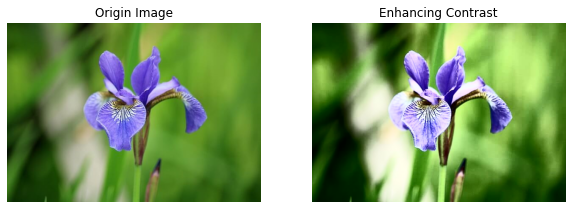

In [57]:
# Load image
image_bgr = cv2.imread("iris.jpg")
# Convert to YUV
image_yuv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2YUV)
# Apply histogram equalization
image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
# Convert to RGB
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
# Show image
fig = plt.figure(figsize=(10, 7))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 2)
plt.imshow(image_rgb), plt.axis("off"),plt.title('Enhancing Contrast')
fig.add_subplot(rows, columns, 1)
plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)), plt.axis("off"),plt.title('Origin Image')
plt.show()

While a detailed explanation of how histogram equalization works is that it transforms the image so that it uses
a wider range of pixel intensities.

While the resulting image often does not look “realistic,” we need to remember that
the image is just a visual representation of the underlying data. If histogram equaliza‐
tion is able to make objects of interest more distinguishable from other objects or
backgrounds (which is not always the case), then it can be a valuable addition to our
image preprocessing pipeline.

### 2.2.6 Binarizing Images
For avoiding the background noise generated in images we will use a Binarization technique.

Thresholding is the process of setting pixels with intensity greater than some value to
be white and less than the value to be black. A more advanced technique is adaptive
thresholding, where the threshold value for a pixel is determined by the pixel intensities of its neighbors. This can be helpful when lighting conditions change over different regions in an image:

<img src='binary.png'>

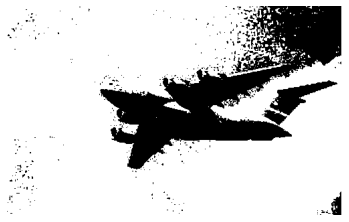

In [22]:
# Load image as grayscale
image_grey = cv2.imread("main.jpg", cv2.IMREAD_GRAYSCALE)
# Apply adaptive thresholding
max_output_value = 255
neighborhood_size = 999
subtract_from_mean = 10
image_binarized = cv2.adaptiveThreshold(image_grey,max_output_value,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,neighborhood_size,subtract_from_mean)
# Show image
plt.imshow(image_binarized, cmap="gray"), plt.axis("off")
plt.show()

Our solution has four important arguments in adaptiveThreshold. 
- max_output_value simply determines the maximum intensity of the output pixel intensities.

cv2.ADAPTIVE_THRESH_GAUSSIAN_C sets a pixel’s threshold to be a weighted sum of the neighboring pixel intensities. The weights are determined by a Gaussian window.
Alternatively we could set the threshold to simply the mean of the neighboring pixels
with cv2.ADAPTIVE_THRESH_MEAN_C:

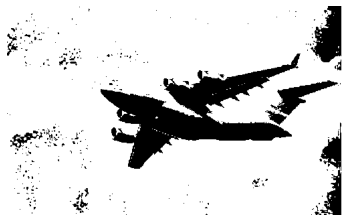

In [90]:
# Apply cv2.ADAPTIVE_THRESH_MEAN_C
image_mean_threshold = cv2.adaptiveThreshold(image_grey,
 max_output_value,
cv2.ADAPTIVE_THRESH_MEAN_C,
cv2.THRESH_BINARY,
neighborhood_size,
subtract_from_mean)
# Show image
plt.imshow(image_mean_threshold, cmap="gray"), plt.axis("off")
plt.show()

The last two parameters are the block size (the size of the neighborhood used to
determine a pixel’s threshold) and a constant subtracted from the calculated thres‐
hold (used to manually fine-tune the threshold).
A major benefit of thresholding is denoising an image—keeping only the most important elements. For example, thresholding is often applied to photos of printed text to
isolate the letters from the page.

### 2.3 Color augmentation
Color augmentation or color jittering deals with altering the color properties of an image by changing its pixel values.

#### Brightness
One way to augment is to change the brightness of the image. The resultant image becomes darker or lighter compared to the original one.

#### Contrast
The contrast is defined as the degree of separation between the darkest and brightest areas of an image. The contrast of the image can also be changed.

#### Saturation
Saturation is the separation between colors of an image.

#### Hue
Hue can be described of as the shade of the colors in an image.

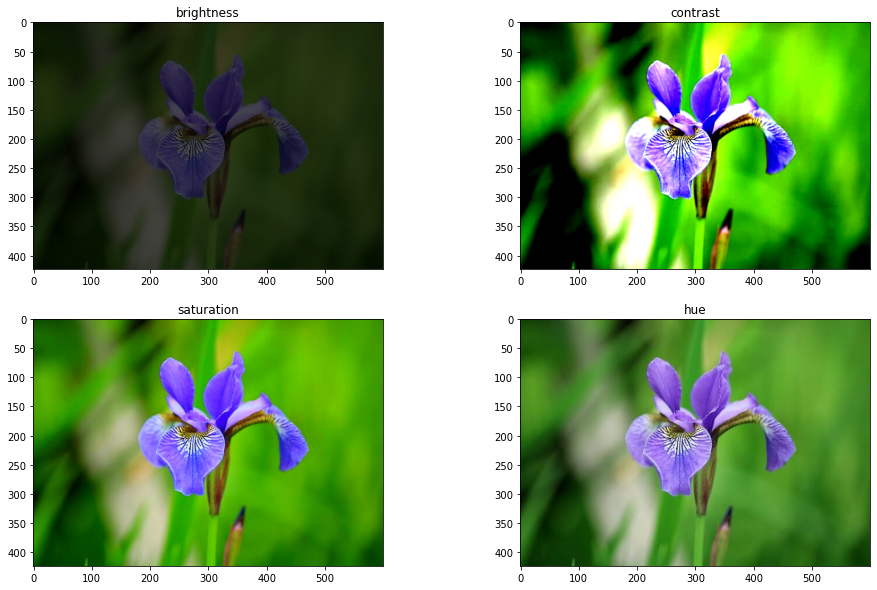

In [209]:
import PIL.Image
import torch
from torchvision import transforms
img = PIL.Image.open('iris.jpg')
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# brightness
loader_transform1 = transforms.ColorJitter(brightness=2)
img1 = loader_transform1(img)
ax[0, 0].set_title(f'brightness')
ax[0, 0].imshow(img1)

# contrast
loader_transform2 = transforms.ColorJitter(contrast=2)
img2 = loader_transform2(img)
ax[0, 1].set_title(f'contrast')
ax[0, 1].imshow(img2)

# saturation
loader_transform3 = transforms.ColorJitter(saturation=2)
img3 = loader_transform3(img)
ax[1, 0].set_title(f'saturation')
ax[1, 0].imshow(img3)
fig.savefig('color augmentation', bbox_inches='tight')

# hue
loader_transform4 = transforms.ColorJitter(hue=0.2)
img4 = loader_transform4(img)
ax[1, 1].set_title(f'hue')
ax[1, 1].imshow(img4)

fig.savefig('color augmentation', bbox_inches='tight')

cac khong gian mau

opencv chuyen ve xu li anh

torch, keras de dua vao mo hinh hoc sau, augmentation

### 2.4. Phương pháp Canny phát hiện edge

Canny là một phương pháp phát hiện edge phổ biến được phát triển bởi John F.Canny vào năm 1986. 
Thực hành thuật toán Canny trên openCV

Tất cả các bước trên được openCV gói gọn trong một hàm số là cv2.Canny(). Trong hàm số này chúng ta sẽ khai báo tham số đầu tiên là hình ảnh đầu vào, tham số thứ 2 và thứ 3 lần lượt là ngưỡng minVal và maxVal.

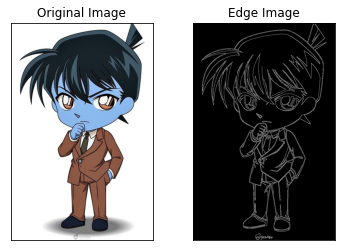

In [56]:
import cv2
import numpy as np
import requests
from matplotlib import pyplot as plt

url = 'https://i.pinimg.com/736x/6d/9c/e0/6d9ce08209b81b28c6ea64012e070003.jpg'
img = _downloadImage(url)

edges = cv2.Canny(img, 100, 200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### 2.5 Denoising

In [170]:
import skimage
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        noisy = skimage.util.random_noise(image, mode='gaussian', seed=None, clip=True)
        return noisy
    elif noise_typ == "s&p":
        row,col = image.shape
        s_vs_p = 0.05
        amount = 0.04
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_11468/115571172.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
C:\Users\ADMIN\AppData\Local\Temp/ipykernel_11468/115571172.py:28: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


(([], []), ([], []))

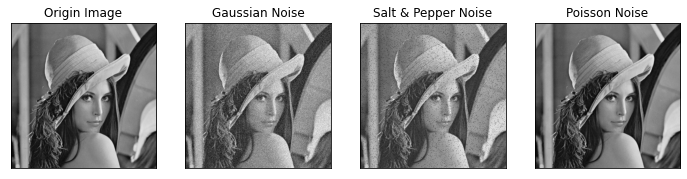

In [171]:
img = cv2.cvtColor(cv2.imread("lena_gray.png"), cv2.COLOR_BGR2GRAY)
gauss_noise = noisy("gauss",img)
sp_noise = noisy("s&p", img)
poisson_noise = noisy("poisson",img)

plt.figure(figsize=(12, 8))
plt.subplot(241),plt.imshow(img, cmap='gray'),plt.title('Origin Image')
plt.xticks([]), plt.yticks([])
plt.subplot(242),plt.imshow(gauss_noise, cmap='gray'),plt.title('Gaussian Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(243),plt.imshow(sp_noise, cmap='gray'),plt.title('Salt & Pepper Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(244),plt.imshow(poisson_noise, cmap='gray'),plt.title('Poisson Noise')
plt.xticks([]), plt.yticks([])

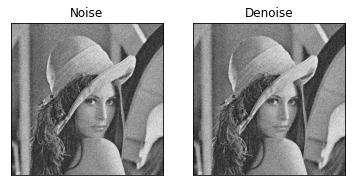

In [192]:
from sklearn.metrics import mean_squared_error
import math
gaussian_img = np.uint8(gauss_noise*255).astype(np.uint8)


dst = cv2.fastNlMeansDenoising(gaussian_img, None, 3, 7, 21)

plt.subplot(121),plt.imshow(gauss_noise, cmap='gray'),plt.title('Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Denoise')
plt.xticks([]), plt.yticks([])
plt.show()


### 2.6 Image Generation
<img src='gan.png'>